In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import cartopy.crs as ccrs

%matplotlib inline

In [2]:
datafile = xr.open_dataset('shared-tacco-ns1004k-cmip-betzy/CAS/CAS-ESM2-0/historical/r1i1p1f1/Omon/tos/gn/latest/tos_Omon_CAS-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc')
datafile

<xarray.Dataset>
Dimensions:    (time: 1980, bnds: 2, lat: 196, lon: 360)
Coordinates:
  * time       (time) object 1850-01-16 13:00:00.000007 ... 2014-12-16 12:00:00
  * lat        (lat) float64 -78.0 -77.0 -76.0 -75.0 ... 87.0 88.0 89.0 90.0
  * lon        (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tos        (time, lat, lon) float32 ...
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          Spin-up documentation
    branch_time_in_child:   674885.0
    branch_time_in_parent:  218635.0
    contact:                He Zhang(zhanghe@mail.iap.ac.cn)
    ...                     ...
    title:                  CAS-ESM2-0 output prepared for CMIP6
    tracking_id:            hdl:21.14100/05567d7b-7cdf-411f-b43c-5b812239a26e
    variable_id:            tos
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by Chinese Academy of S...
    cmor_version:           3.5.0

## Ocean exercise:
* Find the right varibale for analysis (CMIP6 variable list) ok
* choos a CMIP6 model and ensemble member in "historical" experiment ok
* check how to calculate ENSO index (hint Nino SST indices and Oceanic Nino Index)
* calcualte nino 3.4 anomalies in 1850 - 2014
* caclulate ONI in 1850 - 2014
* plot timeseries of ONI in 1850 - 2014
* find out the El Nino and La Nina event and compare with the observations.

#### Niño 3.4 (5N-5S, 170W-120W):  
The  Niño 3.4 anomalies may be thought of as representing the average equatorial SSTs across the Pacific from about the dateline to the South American coast. 
The Niño 3.4 index typically uses a 5-month running mean, and El Niño or La  Niña events are defined when the Niño 3.4 SSTs exceed +/- 0.4C for a period of six months or more.

In [3]:
tos = datafile['tos'].sel(time=slice('1840','2014'), lat=slice(-5,5), lon=slice(190,240))
tos_all = datafile['tos'].sel(time=slice('1840','2014'))

In [4]:
weights_tos = np.cos(np.deg2rad(tos.lat))
tos_weighted = tos.weighted(weights_tos) 
tos_weighted_mean = tos.mean(("lon", "lat"))

#### Calculate the climatology by taking the mean of the weighted tos (temperature ocean surface), then subtract the climatology from the mean to find the anomoaly.

In [5]:
climatology = tos_weighted_mean.mean()
anomaly = tos - climatology

Text(0.5, 0, 'Time [Year]')

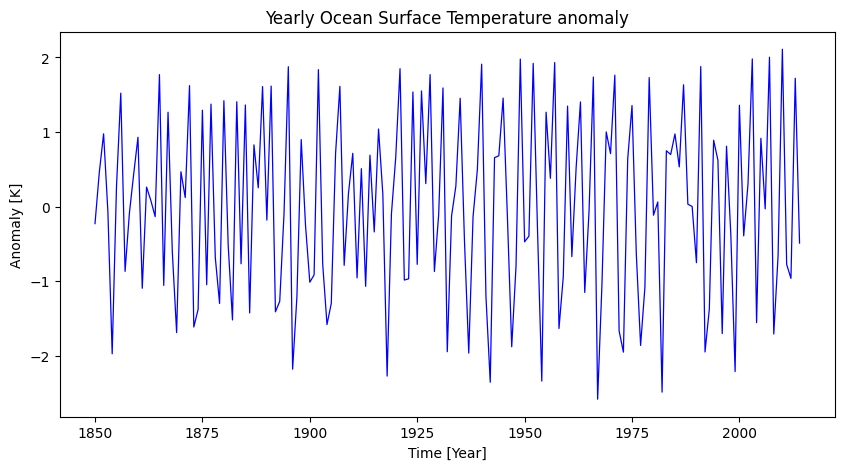

In [6]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,5))
anomaly_group = anomaly.groupby('time.year').mean(("lon", "lat", 'time')).plot(linewidth = 0.9, color='b',  label='Ocean surface temperature [tos]')
ax.set_title('Yearly Ocean Surface Temperature anomaly')
ax.set_ylabel('Anomaly [K]')
ax.set_xlabel('Time [Year]')

#### Selecting Niño 3.4 data, which makes use of the where() method:

In [8]:
ocean_surface_temp_nino34 = tos.sel(lat=slice(-5, 5), lon=slice(190, 240))
ocean_surface_temp_nino34 = tos.where((tos.lat < 5) & (tos.lat > -5) & (tos.lon > 190) & (tos.lon < 240), drop=True)

#### Plot the selected region to the definition of the Niño 3.4:

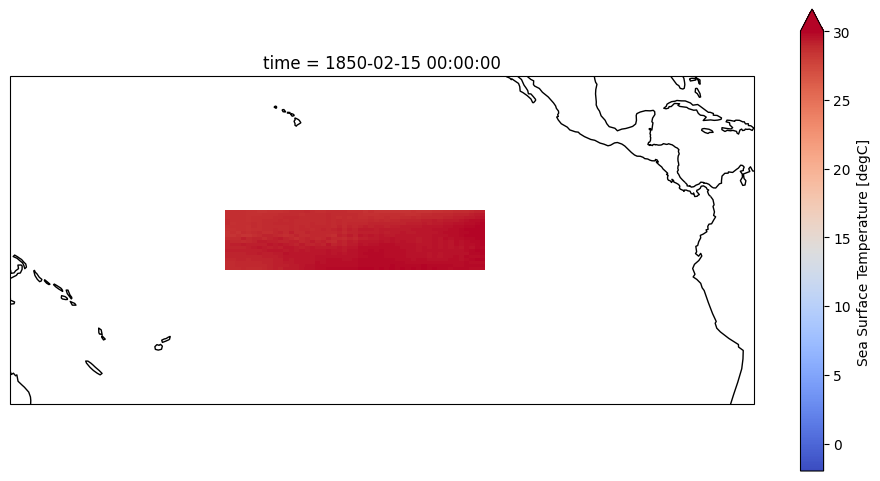

In [9]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.coastlines()
ocean_surface_temp_nino34.isel(time=1).plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-2, vmax=30, cmap='coolwarm')
ax.set_extent((150, 290, 10, -10))

There are three main steps to obtain the anomalies from the Niño 3.4:
* First, we use the groupby() method to convert to monthly data.
* Second, we subtract the mean sea-surface temperature (SST) from the monthly data.
* Finally, we obtain the anomalies by computing a weighted average.

In [17]:
climatology = tos.groupby('time.month')
anomaly = climatology - climatology.mean('time')
std = anomaly.std()   #standard deviation

value_weighted = anomaly.weighted(ocean_surface_temp_nino34).mean(dim=['lat', 'lon'])
value_weighted_rolling_mean = value_weighted.rolling(time=5).mean() #calculates the rolling mean over the climatology.

Text(0, 0.5, 'Sea Surface Temperature Anomaly [K]')

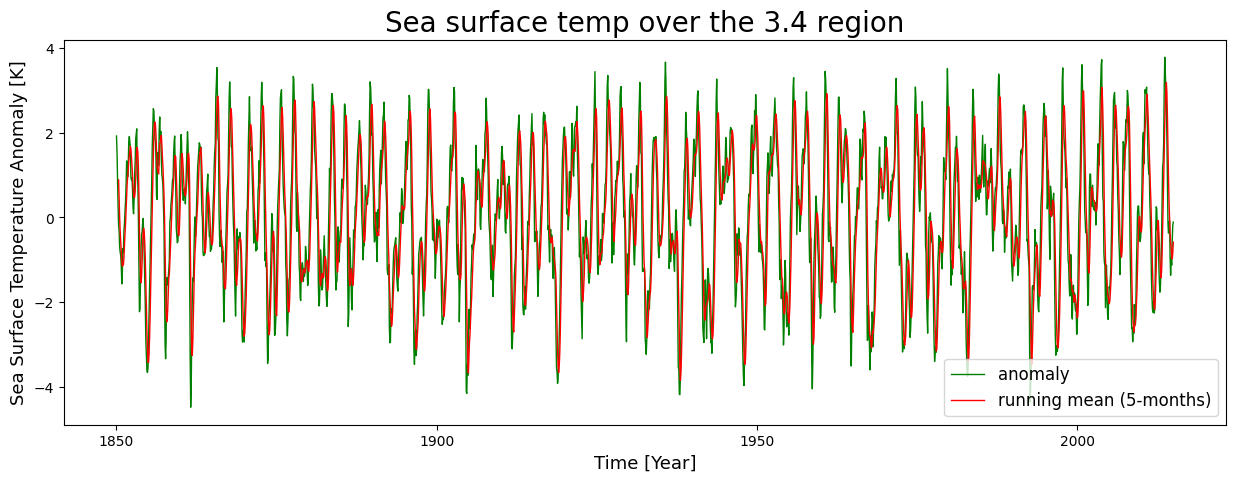

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
value_weighted.plot(linewidth=1, color='green', label = ('anomaly'))
value_weighted_rolling_mean.plot(color='r' ,linewidth=1, label =('running mean (5-months)')) 

normalized_value_weighted_rolling_mean = value_weighted_rolling_mean / std

plt.legend(fontsize=12)
plt.title('Sea surface temp over the 3.4 region', fontsize=20);
plt.xlabel('Time [Year]', fontsize=13)
plt.ylabel('Sea Surface Temperature Anomaly [K]', fontsize=13)


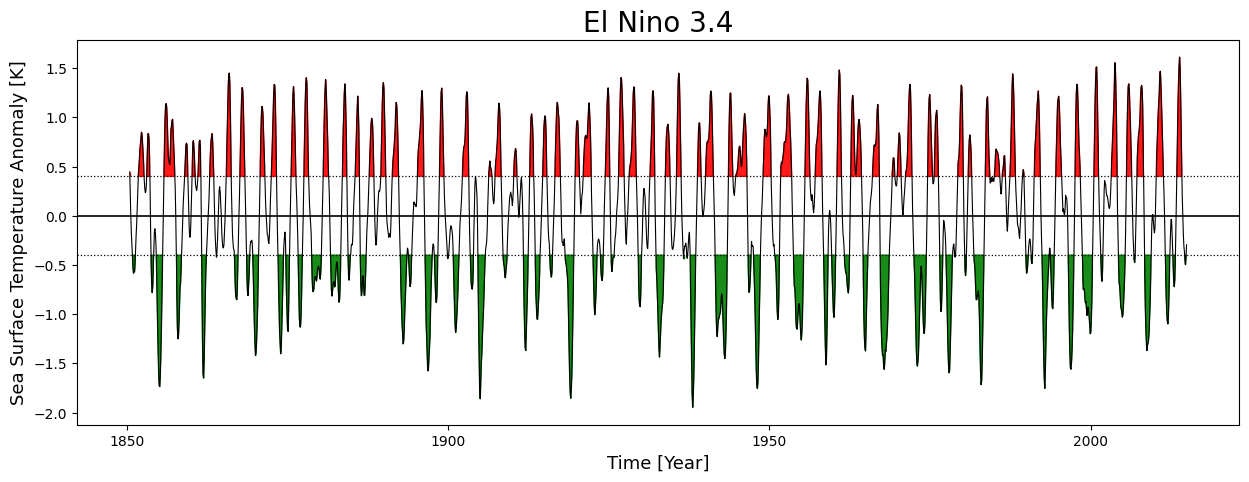

In [19]:
fig = plt.figure(figsize=(15, 5))
plt.fill_between(
    normalized_value_weighted_rolling_mean.time.data,
    normalized_value_weighted_rolling_mean.where(
        normalized_value_weighted_rolling_mean >= 0.4
    ).data,
    0.4,
    color='red',
    alpha=0.9,
)
plt.fill_between(
    normalized_value_weighted_rolling_mean.time.data,
    normalized_value_weighted_rolling_mean.where(
        normalized_value_weighted_rolling_mean <= -0.4
    ).data,
    -0.4,
    color='green',
    alpha=0.9,
)

normalized_value_weighted_rolling_mean.plot(color='black', linewidth=0.8)
plt.axhline(0, color='black', lw=1.2)
plt.axhline(0.4, color='black', linewidth=0.9, linestyle='dotted')
plt.axhline(-0.4, color='black', linewidth=0.9, linestyle='dotted')
plt.title('El Nino 3.4', fontsize = 20);
plt.xlabel('Time [Year]', fontsize=13)
plt.ylabel('Sea Surface Temperature Anomaly [K]', fontsize=13)
plt.savefig('index_3_4.png')